In [1]:
import numpy as np
import pandas as pd
import functions as f
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Context

When modeling dynamic systems with many candidate variables, only a few may be relevant. Machine learning helps separate variable selection from functional form specification, enabling researchers to identify key features through *feature importance*. 

Unlike classical regression, which relies on strong assumptions and p-values for inference, ML methods can reveal variable relevance without requiring closed-form solutions. P-values, while popular, suffer from key limitations:

1. reliance on strict assumptions, 
2. instability under multicollinearity, 
3. misinterpretation of probabilities, 
4. lack of out-of-sample robustness. 

These caveats highlight why ML approaches can offer a more flexible and informative alternative to traditional hypothesis-driven statistical methods.

The two methods I will explore are:

* Mean-Decrease Impurity (MDI) - which fixes issues 1 to 3
* Mean-Decrease Accuracy (MDA) - which fixes all issues 1 to 4

in the *per-feature* and *clustered* versions.

# Defining the sample

We simulate a sample that consists of:

* Informative features (*I_\**) which form the basis for defining the target variable *y*  
* Noise features (*N_\**) which carry no information relevant for explaining *y*  
* Redundant features (*R_\**) which are constructed as random linear combinations of the informative features, possibly with some added noise
* The target variable *y*, being a complex function of the informative featrues

We select features with diverse distributions to capture various data characteristics.

In [2]:
# Generating the features and labels

df = pd.DataFrame()

np.random.seed(42)  # For reproducibility

# Informative features
df['I_1'] = np.random.normal(loc=0, scale=1, size=1000)  # Normal 1
df['I_2'] = np.random.normal(loc=5, scale=2, size=1000)  # Normal 2
df['I_3'] = np.random.lognormal(mean=0, sigma=1, size=1000)  # Log-normal 1
df['I_4'] = np.random.lognormal(mean=1, sigma=0.5, size=1000)  # Log-normal 2
df['I_5'] = np.random.standard_t(df=2, size=1000)  # Fat-tailed (Student's t with df=2)
df['I_6'] = np.random.pareto(a=2, size=1000)  # Pareto distribution
df['I_7'] = np.random.gamma(shape=5, scale=1, size=1000)  # Gamma distribution

# Redundant features as random linear combinations of informative features with noise
coeffs = np.random.uniform(-1, 1, size=(7, 7))
print(f'Coeffs: \n {pd.DataFrame(coeffs)}')

for i in range(7):
    df[f'R_{i+1}'] = sum(coeffs[i, j] * df[f'I_{j+1}'] for j in range(7)) + np.random.normal(loc=0, scale=1, size=1000)

df = (df - df.mean()) / df.std()

# Noise features
df['N_1'] = np.random.normal(loc=0, scale=1, size=1000)  # Normal 1
df['N_2'] = np.random.normal(loc=5, scale=2, size=1000)  # Normal 2
df['N_3'] = np.random.lognormal(mean=0, sigma=1, size=1000)  # Log-normal 1
df['N_4'] = np.random.lognormal(mean=1, sigma=0.5, size=1000)  # Log-normal 2
df['N_5'] = np.random.standard_t(df=2, size=1000)  # Fat-tailed (Student's t with df=2)
df['N_6'] = np.random.pareto(a=2, size=1000)  # Pareto distribution
df['N_7'] = np.random.gamma(shape=5, scale=1, size=1000)  # Gamma distribution

df = (df - df.mean()) / df.std()

# Target variable
df['y'] = (df['I_1'] + df['I_2']**2 + df['I_3'] + df['I_4'] * df['I_5'] + 
            2 * df['I_6'] + df['I_7'] + np.random.normal(loc=0, scale=1, size=1000))
df['y'] = (df['y'] > df['y'].mean()).astype(int)

Coeffs: 
           0         1         2         3         4         5         6
0  0.822512 -0.192487 -0.584501  0.297494  0.742374  0.496638  0.737514
1  0.073109  0.503752 -0.719871 -0.303451 -0.220902  0.022591  0.858153
2  0.748593 -0.730949 -0.654421 -0.284719 -0.418512  0.229542  0.805552
3  0.924583  0.307206  0.676318  0.050404 -0.583346  0.049377  0.110165
4  0.484915 -0.560234 -0.263379 -0.271945  0.918879 -0.112110  0.510188
5  0.501623 -0.468912  0.143739  0.788606 -0.049605  0.890235 -0.571084
6 -0.851682  0.782908  0.695362  0.985180  0.358787  0.873376  0.653898


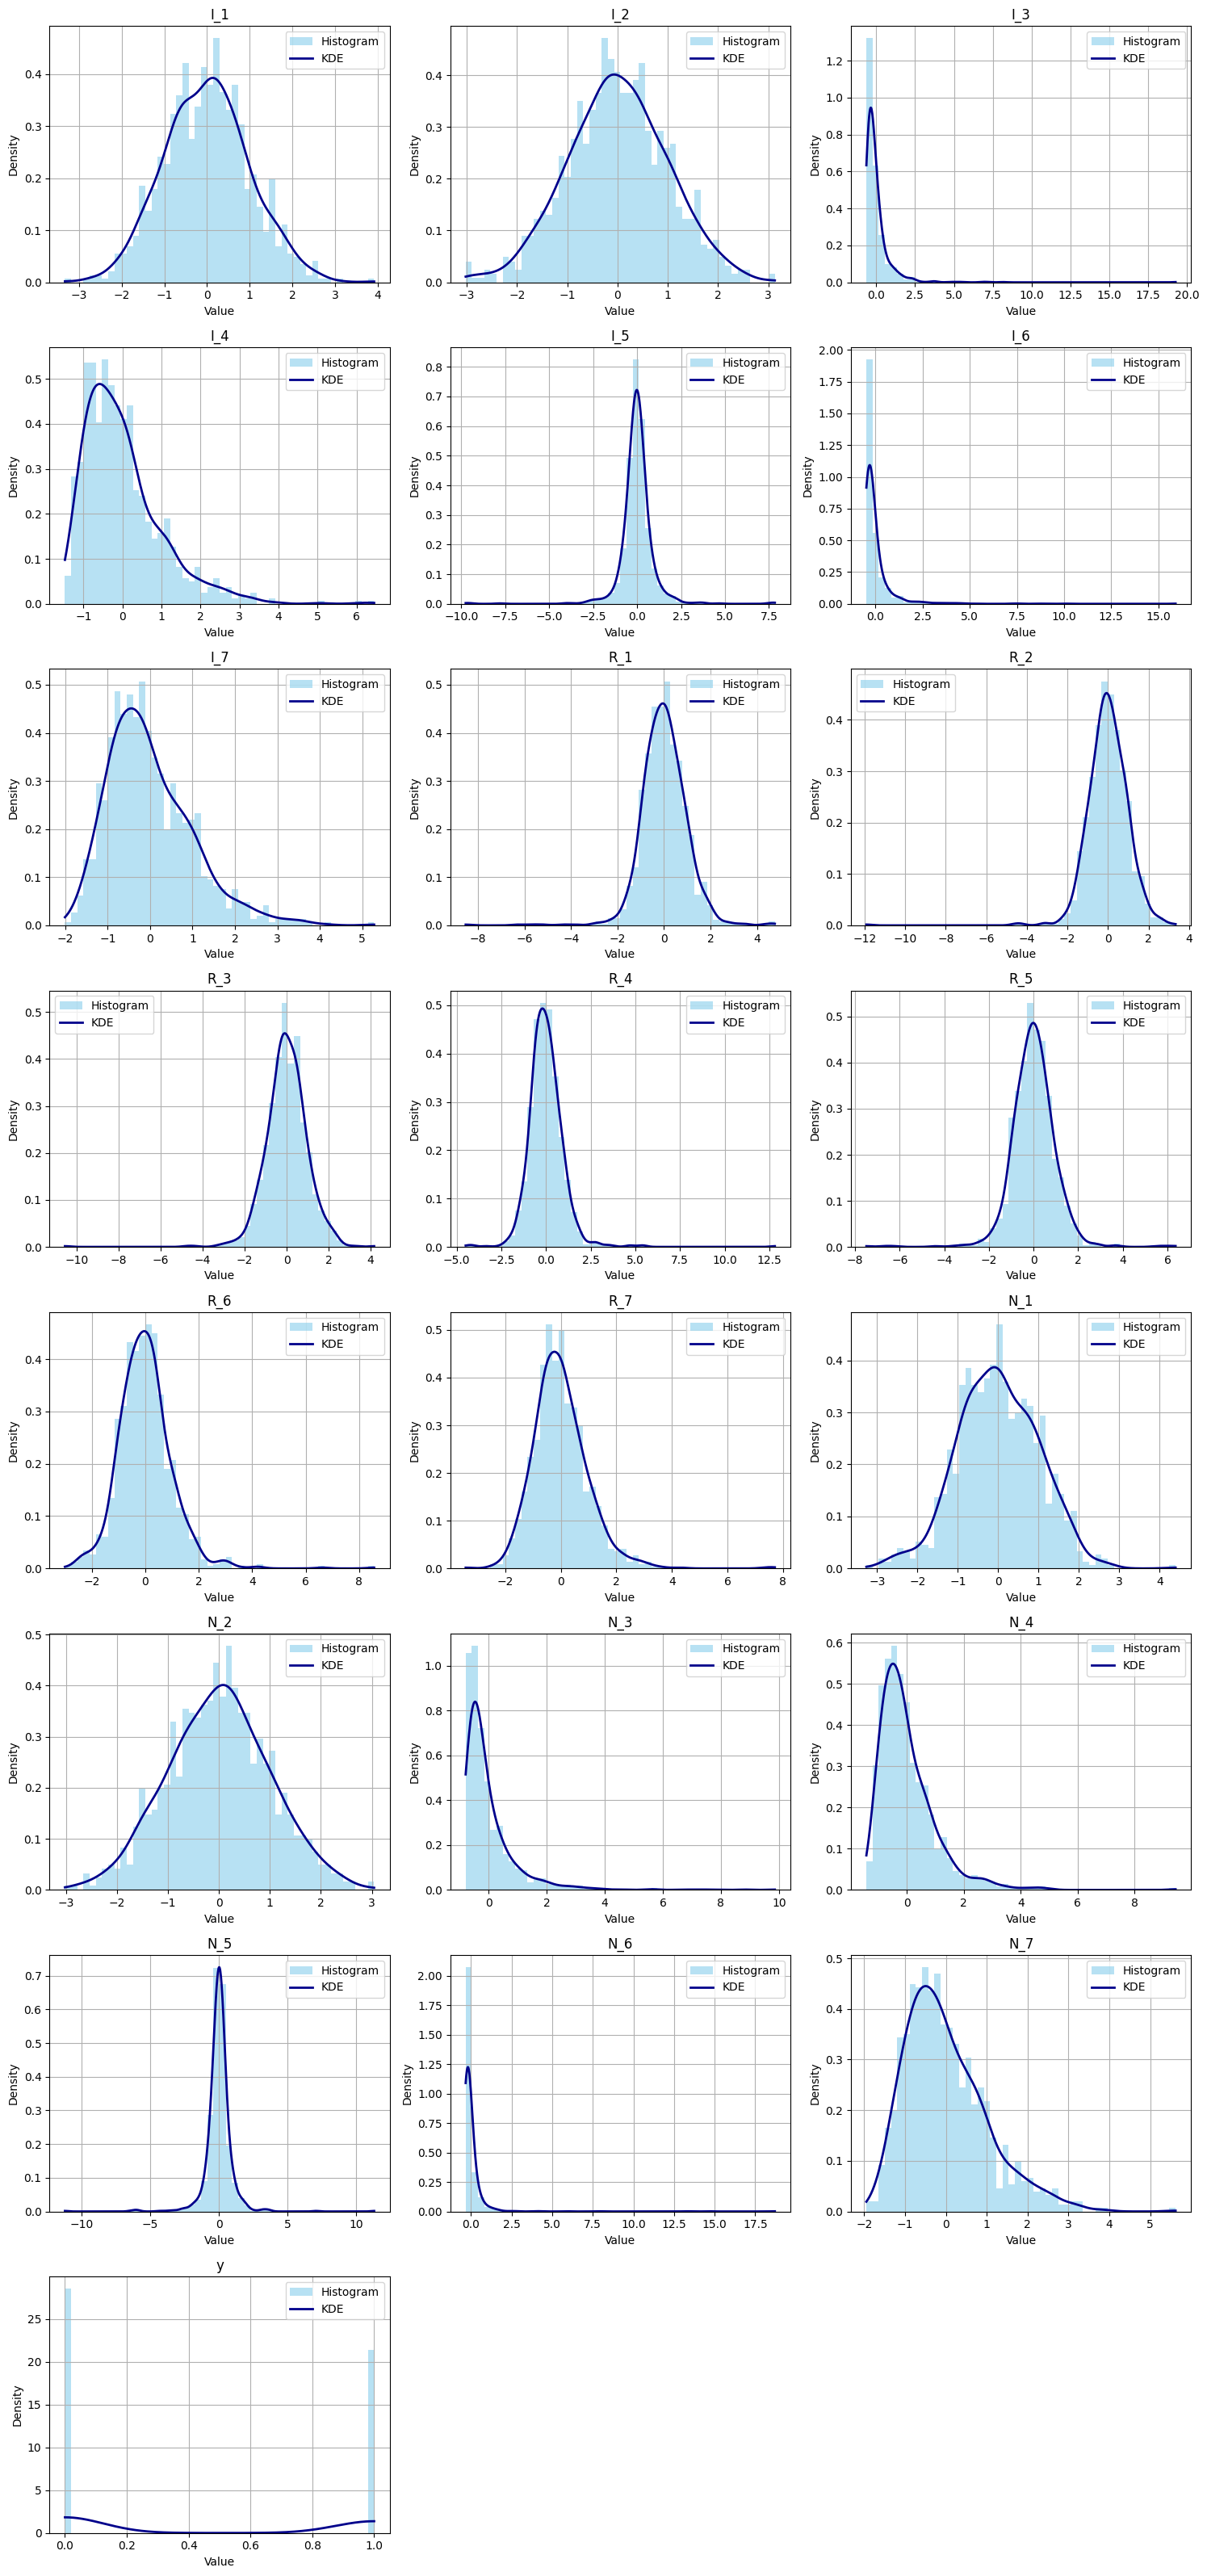

In [3]:
def plot_dataframe_histograms(df):

    # Plot histograms and KDEs for all columns in a DataFrame

    num_features = df.shape[1]
    cols = int(np.ceil(np.sqrt(num_features)/2))
    rows = int(np.ceil(num_features / cols))

    plt.figure(figsize=(15, 4 * rows))

    for i, col in enumerate(df.columns):
        data = df[col].dropna()
        plt.subplot(rows, cols, i + 1)

        # Histogram
        plt.hist(data, bins=50, density=True, alpha=0.6, color='skyblue', label='Histogram')

        # KDE
        kde = gaussian_kde(data)
        x_vals = np.linspace(data.min(), data.max(), 1000)
        y_vals = kde(x_vals)
        plt.plot(x_vals, y_vals, color='darkblue', lw=2, label='KDE')

        plt.title(f'{col}')
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()

plot_dataframe_histograms(df)

# Mean-Decrease Impurity (MDI)

MDI is a method for estimating feature importance in tree-based models. 

At each node in a classification or regression tree, the algorithm selects a feature and threshold that best reduce impurity, typically measured by the Gini index or entropy. Pure nodes contain similar labels, while impure ones have more variability. The reduction in impurity from a split is called information gain. 

MDI for a feature is the weighted sum of its information gains across all nodes where it is used. In ensemble models like random forests, MDI values are averaged across trees, yielding a robust feature ranking. Frequent, effective splits lead to higher MDI scores (0 to 1). 

MDI avoids several issues tied to p-values: 

1. it requires no strong distributional assumptions, 
2. it is based on bootstrapped samples,
3. it is model-agnostic, not tied to a specific algebraic form.

While MDI helps mitigate problems like overfitting and false discoveries, it doesn’t directly account for out-of-sample validation. Still, MDI remains a powerful tool for identifying key features in complex, high-dimensional datasets.

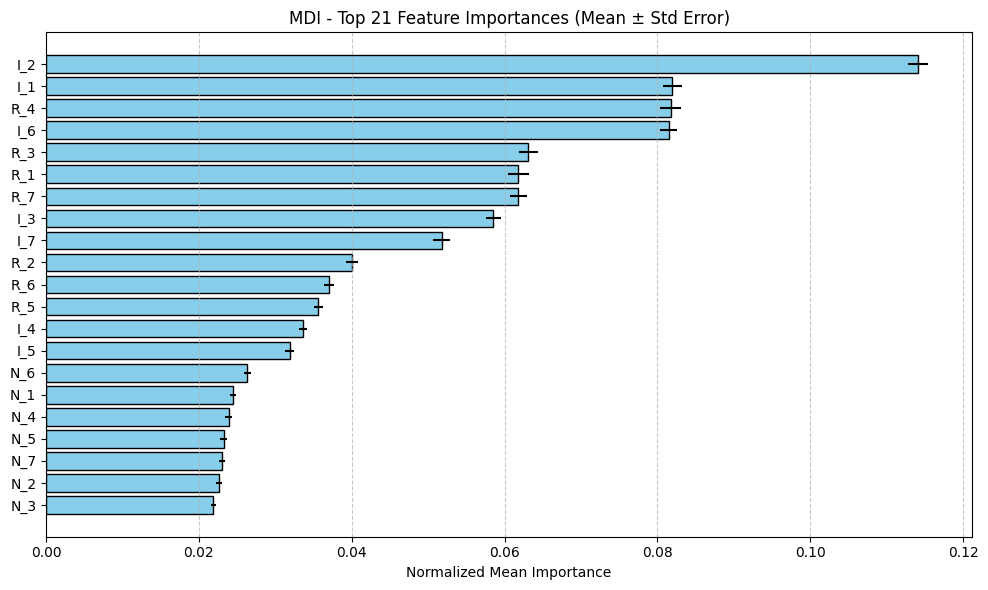

In [4]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

feat_importances = f.feat_imp_mdi(X, y, classifier=True) # Function defined in script functions.py

As we can see, the MDI did a good job at identifying features that carry information, and classified all noise features as the ones that reduce the impurity the least. Certain informative features were classified as less informative than the redundant features, which can be assiociated to substitution effects.

# Mean-Decrease Accuracy (MDA)

The MDA method allows also for out-of-sample validation, adressing the last caveat of the p-values method.

MDA works as follows:

* Fit a model and compute its cross-validated performance.
* For each feature, shuffle its values across observations and recompute the performance.
* The drop in performance indicates the MDA for that feature.

If shuffling a feature leads to a significant performance drop, the feature is considered important. Like MDI, MDA is averaged across multiple folds in a cross-validation scheme, making it robust to variance.

Despite its name, MDA does not require accuracy as the performance metric. The metrics we will use are:

* log_loss (cross-entropy loss) for classification tasks - captures not just whether predictions are correct but how confident the model is—making it more informative than plain accuracy
* mean_squared_error for regression tasks - penalizes larger errors more heavily, which is standard for regression evaluation

This makes sure the prediction confidence matters as much as correctness.

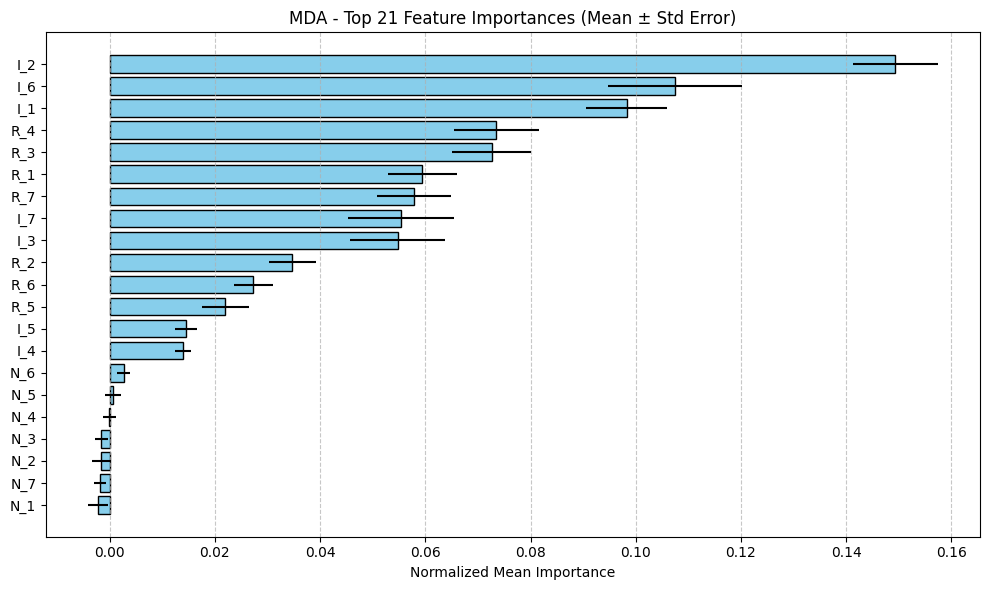

In [5]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

feat_importances = f.feat_imp_mda(X, y) # Function defined in script functions.py

The MDA did an even better job at identifying features that carry information, and classified all noise features as the ones that reduce the impurity the least. Certain informative features were classified as less informative than the redundant features, which can be assiociated to substitution effects.

Features that were classified low, like $I_4$ and $I_5$, have the least effect on the target *y*, as $y = ... I_4*I_5 ...$ - the multiplication makes these variables low-valued.

# Clustered Feature Importance (CFI)

When features are codependent, decreases in one’s importance are offset by increases in another’s, causing substitution effects that hinder robust evaluation. While PCA can address this, a more interpretable and stable approach is to cluster similar features and compute importance at the cluster level. This avoids changing the basis and yields more intuitive results by grouping correlated features, mitigating substitution effects among redundant predictors.

Steps to implement CFI:

1. **Feature Projection:**  
   Project features into a metric space to measure similarity, using correlation-based distances or information-theoretic measures like mutual information.

2. **Clustering:**  
   Determine the optimal number and composition of clusters using methods such as those in *Section 4: Optimal Clustering*. Features within a cluster share high mutual information; features in different clusters share less. For features overlapping multiple clusters, reduce multicollinearity by replacing features with residuals orthogonal to other clusters, obtained by regressing cluster features on features from other clusters.

3. **Calculate Clustered Importance:**  
   - *Clustered MDI:* Sum the MDI values of all features in a cluster.  
   - *Clustered MDA:* Perform MDA by permuting all features in a cluster simultaneously instead of individually.

This approach yields the collective importance of feature clusters.

### 1. Feature projection

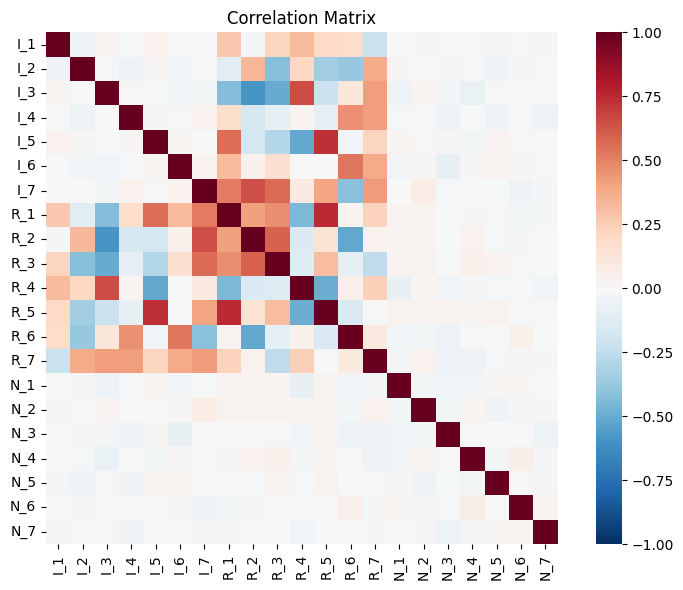

In [6]:
corr_matrix = X.corr()

f.plot_corr_matrix(corr_matrix)

dist_matrix = np.sqrt(0.5*(1 - corr_matrix)) # Correlation based metric

### 2. Clustering

Using methods from section *4. Optimal Clustering* we determine the number of clusters to be 10.

We see that for this amount of clusters the algorithm does a good job with separating the noise features from the informative and redundant features.

Info: max_n_clusers limited to 10. Change test_size parameter to increase it.


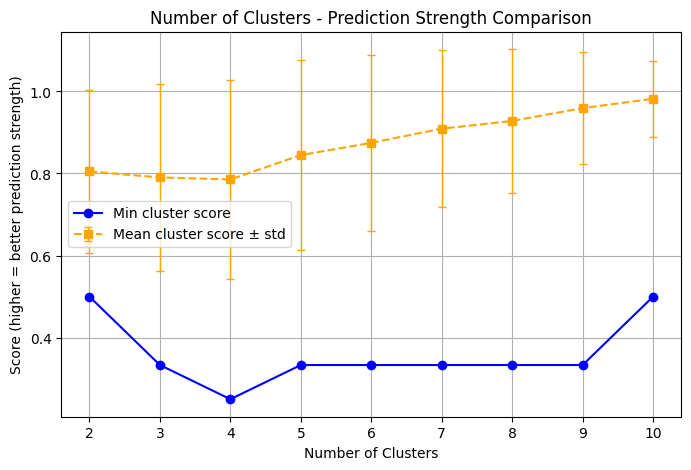

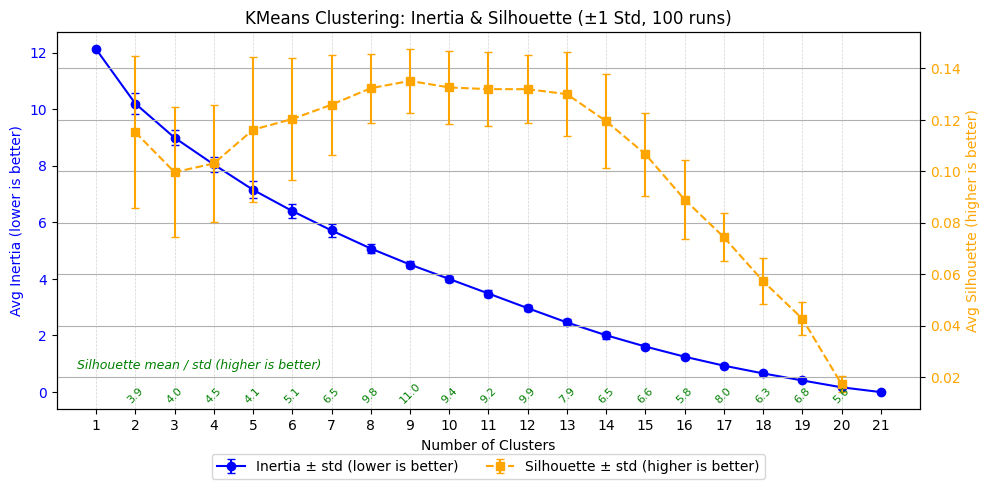

In [7]:
clusters_prediction_stats = f.clustering_predictions_strength(dist_matrix, max_n_clusters = dist_matrix.shape[0], test_size=0.5, plot=True)
clusters_elbow_stats = f.clustering_elbow_plot(dist_matrix, max_n_clusters = dist_matrix.shape[0], plot=True)

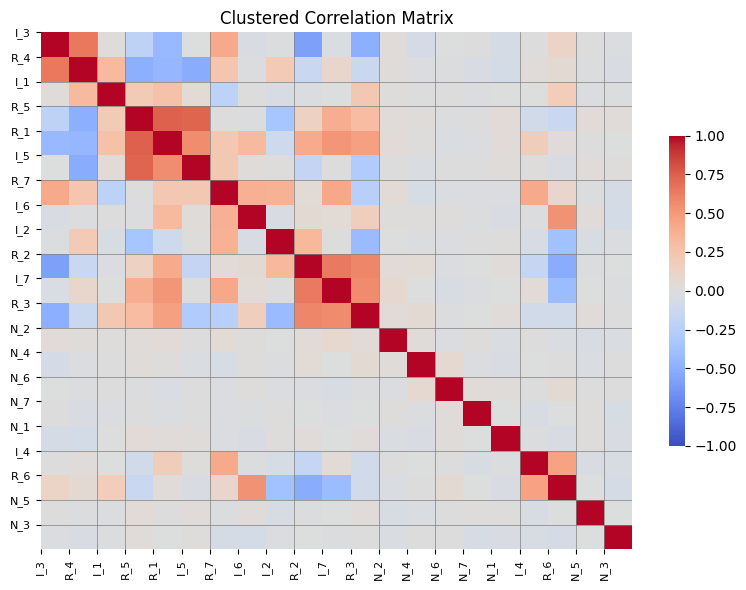

Cluster nr 0: ['I_3' 'R_4']
Cluster nr 1: ['I_1']
Cluster nr 2: ['I_5' 'R_1' 'R_5']
Cluster nr 3: ['I_2' 'I_6' 'R_7']
Cluster nr 4: ['I_7' 'R_2' 'R_3']
Cluster nr 5: ['N_2' 'N_4']
Cluster nr 6: ['N_1' 'N_6' 'N_7']
Cluster nr 7: ['I_4' 'R_6']
Cluster nr 8: ['N_5']
Cluster nr 9: ['N_3']


In [8]:
n_clusters = 10

corr_matrix = X.corr()
dist_matrix = np.sqrt(0.5*(1 - corr_matrix))

labels, names = f.find_clustres_with_best_silhouette(dist_matrix, n_clusters)

f.sort_clustered_corr_matrix(corr_matrix, labels, label_spacing = 1, plot = True)

# Print components of each cluster
for cluster_nr in np.unique(labels):
    print(f'Cluster nr {cluster_nr}: {[names[labels == cluster_nr]][0].values}')

To further separate feature clusters and reduce multicollinearity, we replace features with their residuals that are orthogonal to features from other clusters. This is done by regressing each feature on the features from all *other* clusters and keeping only the residual.

For a given clustering of features $C_1, C_2, \dots, C_n$, and a feature $f_k \in C_k$, we fit a linear regression:

$f_k = a_{k,0} + \sum_{f_i \in (C_1 \cup \dots \cup C_{k-1} \cup C_{k+1} \cup \dots \cup C_n)} a_{k,i} \cdot f_i + \epsilon_k$

We then replace $f_k$ with its residual $\epsilon_k$.

This approach removes shared information between clusters, which helps mitigate substitution effects and improves the stability of feature importance estimates. Unlike PCA, which change the basis and obscure interpretability, residualization retains the original feature structure, making results easier to interpret and explain.

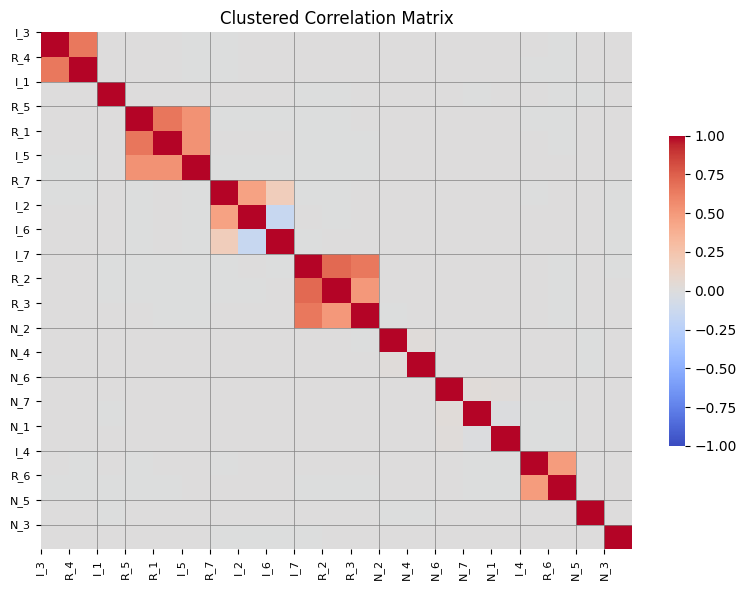

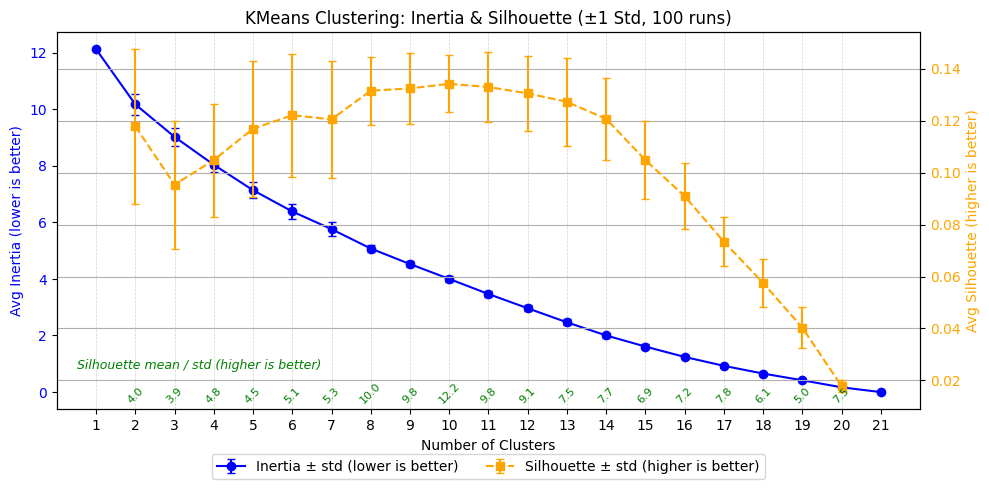

In [9]:
# Residualization
X_resid = f.residualize_features_by_cluster(X, labels)

corr_matrix_resid = X_resid.corr()

dist_matrix_resid = np.sqrt(0.5*(1 - corr_matrix_resid))

corr_matrix_resid = f.sort_clustered_corr_matrix(corr_matrix_resid, labels, label_spacing = 1, plot = True)

clusters_elbow_stats = f.clustering_elbow_plot(dist_matrix, max_n_clusters = dist_matrix.shape[0], plot=True)

### 3. Calculate Clustered Importance (MDI and MDA)

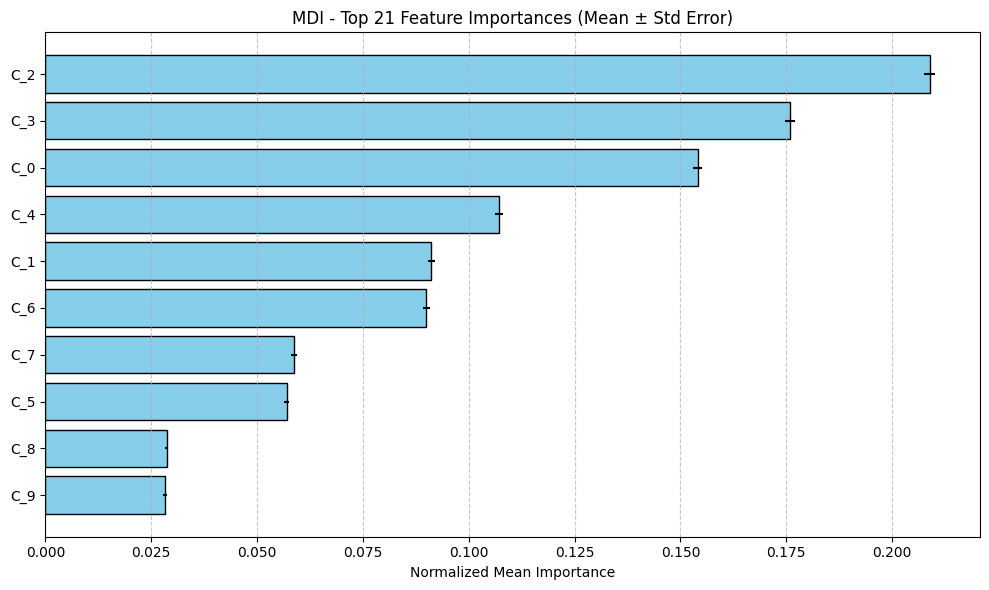

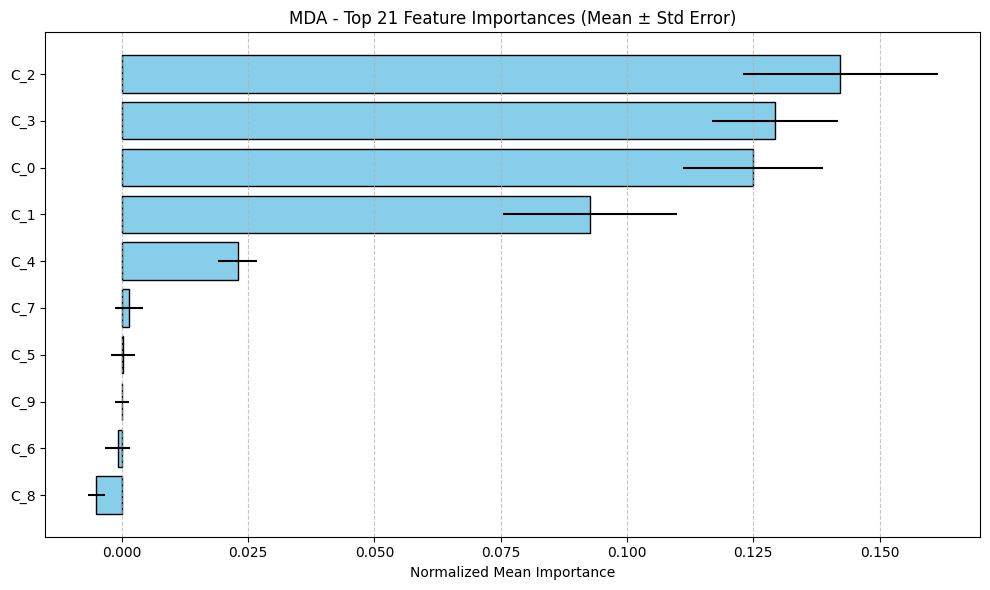

In [10]:
feat_importances = f.feat_imp_mdi(X_resid, y, feat_labels = labels)
feat_importances = f.feat_imp_mda(X_resid, y, feat_labels = labels)

Again, both methods effectively identify clusters containing informative features, with MDA revealing the differences more clearly than MDI. Clusters identified as important are marked with triple exclamation marks (!!!).

Although cluster 7 contains informative features, they likely became non-informative after the residualization step, as most of the relevant information had already been captured by clusters 0 - 4. All clusters containing noise were identified as not informative.


* !!! Cluster nr 0: ['I_3' 'R_4']
* !!! Cluster nr 1: ['I_1']
* !!! Cluster nr 2: ['I_5' 'R_1' 'R_5']
* !!! Cluster nr 3: ['I_2' 'I_6' 'R_7']
* !!! Cluster nr 4: ['I_7' 'R_2' 'R_3']
* Cluster nr 5: ['N_2' 'N_4']
* Cluster nr 6: ['N_1' 'N_6' 'N_7']
* Cluster nr 7: ['I_4' 'R_6']
* Cluster nr 8: ['N_5']
* Cluster nr 9: ['N_3']